# **HW5**

In this notebook, our focus is on employing both 2D-UNet and 3D-UNet models to perform segmentation on a set of 30 volumetric medical images. Your task involves completing the designated sections of the notebook and subsequently comparing the outcomes achieved by the 2D and 3D models in terms of segmentation performance.

- Name: Amir Mohammad Ezzati
- Student id: 402212269

# Package and modules

In [ ]:
!pip install wandb

In [4]:
import wandb
wandb.login(key='f63f6bf237335da137544dff247f145d2db7f47a')

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
import cv2
import torch
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import random
from google.colab import drive

In [6]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data

In this step, your objective is to load data from the provided numpy file. Given that the images have varying numbers of slices, your task is to add zero-padded slices to ensure that all images contain a standardized total of 208 slices



In [7]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE" -O dataset.npy && rm -rf /tmp/cookies.txt

--2024-01-07 17:01:25--  https://docs.google.com/uc?export=download&confirm=t&id=1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE
Resolving docs.google.com (docs.google.com)... 173.194.212.102, 173.194.212.100, 173.194.212.113, ...
Connecting to docs.google.com (docs.google.com)|173.194.212.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q3ioo3no8jne67ivlr9ju3u9voq58c37/1704646875000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=fd926815-3641-430b-ace3-a0279c54c785 [following]
--2024-01-07 17:01:25--  https://doc-0k-60-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/q3ioo3no8jne67ivlr9ju3u9voq58c37/1704646875000/04723003834046181912/*/1DXe9f_8k2_iPdJsrz2ktMXmMw2G2qPGE?e=download&uuid=fd926815-3641-430b-ace3-a0279c54c785
Resolving doc-0k-60-docs.googleusercontent.com (doc-0k-60-docs.googleusercontent.com)... 173.194.216.

In [8]:
dataset_path = 'dataset.npy'
labeled_images = np.load(dataset_path, allow_pickle=True)
ORGAN_idx = 6
ORGAN = 'liver'
image_shape = (128, 128)
image_slices = 208

data_X = []
data_Y = []
for idx in range(len(labeled_images)):
    xx = labeled_images[idx].get("image")
    yy = labeled_images[idx].get("label")

    yy[np.where(yy != ORGAN_idx)] = 0
    yy[np.where(yy == ORGAN_idx)] = 1

    x = []
    y = []
    for i in range(len(xx)):
        x.append(cv2.resize(xx[i,:,:], image_shape))
        y.append(cv2.resize(yy[i,:,:], image_shape))
    x = np.asarray(x)
    y = np.asarray(y)

    # -------------------------------- YOUR CODE --------------------------------
    padded_slices = image_slices - x.shape[0]
    pad = [(0, padded_slices), (0, 0), (0, 0)]

    x_padded = np.pad(x, pad)
    y_padded = np.pad(y, pad)
    data_X.append([x_padded])
    data_Y.append([y_padded])
    # -------------------------------- YOUR CODE --------------------------------

data_X = np.asarray(data_X)
data_Y = np.asarray(data_Y)
print(data_X.shape)
print(data_Y.shape)

(30, 1, 208, 128, 128)
(30, 1, 208, 128, 128)


In [9]:
n_train, n_valid = 20, 10

train_X = data_X[:n_train]
train_Y = data_Y[:n_train]

# valid_X = data_X[:n_train]
# valid_Y = data_Y[:n_train]

valid_X = data_X[n_train:n_train+n_valid]
valid_Y = data_Y[n_train:n_train+n_valid]

print(train_X.shape, train_Y.shape)
print(valid_X.shape, valid_Y.shape)

(20, 1, 208, 128, 128) (20, 1, 208, 128, 128)
(10, 1, 208, 128, 128) (10, 1, 208, 128, 128)


In the next cell write code to visualize some of the slices randomly from the dataset

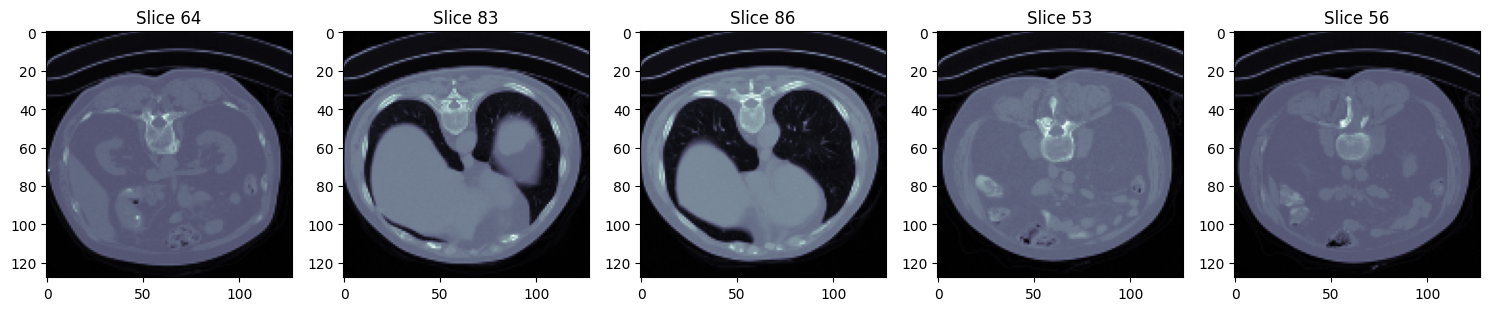

In [10]:
# -------------------------------- YOUR CODE --------------------------------

def visualize_random_image(dataset, n):
  image = dataset[np.random.randint(dataset.shape[0])]

  figure, axes = plt.subplots(1, n, figsize=(3 * n, 3))
  i = 0
  while i < n:
    random_index = np.random.randint(0, image.shape[1])
    random_slice = image[:, random_index]

    if not np.array_equal(random_slice, np.zeros(random_slice.shape)):
      axes[i].set_title("Slice " + str(random_index))
      axes[i].imshow(random_slice[0], cmap='bone')
      i += 1

  figure.tight_layout()
  plt.show()


visualize_random_image(train_X, 5)
# -------------------------------- YOUR CODE --------------------------------

# Utils

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [12]:
def pad_to_shape(this, shp):
    if len(shp) == 4:
        pad = (0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    elif len(shp) == 5:
        pad = (0, shp[4] - this.shape[4], 0, shp[3] - this.shape[3], 0, shp[2] - this.shape[2])
    return F.pad(this, pad)

Write a function that computes the dice score between a batch of prediction and ground truths.

In [13]:
def dice_score(y_pred_bin, y_true):
    """
    Args:
        y_pred_bin: shape => (batch_size, 1, h, w)
        y_true: shape => (batch_size, 1, h, w)

    Returns:
        : shape => (batch_size, dice_score)
    """

    # -------------------------------- YOUR CODE --------------------------------
    batch_size = y_pred_bin.shape[0]
    dices = []
    for i in range(batch_size):
      pred, target = y_pred_bin[i], y_true[i]

      top = 2 *  torch.sum(pred * target)
      union = torch.sum(pred + target)
      eps = torch.ones_like(union) * 1e-5
      bottom = torch.max(union, eps)
      dice = torch.mean(top / bottom)

      dices.append(dice)

    return torch.asarray(dices)
    # -------------------------------- YOUR CODE --------------------------------

# Part 1: 2D UNet

In this section we are going to use a 2D UNet to train a segmentation model.

## Part 1.1: Model Definition

First we need to implement the model architecture. The necessary modules are created in the init functions. Complete the forward method for the UNet model.

In [16]:
class First2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout=False):
        super(First2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)


class Encoder2D(nn.Module):
    def __init__(
            self, in_channels, middle_channels, out_channels,
            dropout=False, downsample_kernel=2
    ):
        super(Encoder2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=downsample_kernel),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class Center2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Center2D, self).__init__()

        layers = [
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.center = nn.Sequential(*layers)

    def forward(self, x):
        return self.center(x)


class Decoder2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Decoder2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout2d(p=dropout))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class Last2D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, softmax=False):
        super(Last2D, self).__init__()

        layers = [
            nn.Conv2d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(middle_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(middle_channels, out_channels, kernel_size=1),
            # nn.Softmax(dim=1)
        ]

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)

In [17]:
class UNet2D(nn.Module):

    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'
        super(UNet2D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First2D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder2D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder2D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last2D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center2D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # -------------------------------- YOUR CODE --------------------------------
        # encoder
        e1 = self.encoder_layers[0](x)
        e2 = self.encoder_layers[1](e1)
        e3 = self.encoder_layers[2](e2)
        e4 = self.encoder_layers[3](e3)

        # bottleneck
        b = self.center(e4)

        # decoder
        c4 = torch.cat((b, e4), dim=1)
        d4 = self.decoder_layers[0](c4)

        c3 = torch.cat((d4, e3), dim=1)
        d3 = self.decoder_layers[1](c3)

        c2 = torch.cat((d3, e2), dim=1)
        d2 = self.decoder_layers[2](c2)

        c1 = torch.cat((d2, e1), dim=1)
        d1 = self.decoder_layers[3](c1)

        return d1

        # -------------------------------- YOUR CODE --------------------------------

## Part 1.2: Dataset Definition

In [14]:
class Dataset2D(Dataset):
    def __init__(self, x, y, Normalization = False):

        self.Normalization = Normalization
        self.slices_x = []
        self.slices_y = []
        for i in range(x.shape[0]):
            for j in range(x.shape[2]):
                sx = x[i, :, j, :, :]
                sy = y[i, :, j, :, :]
                if sy.sum() > 0:
                    self.slices_x.append(sx)
                    self.slices_y.append(sy)

    def __len__(self):
        return len(self.slices_x) # number of samples


    def __getitem__(self, index): # sampling method. used by DataLoader.
        x = self.slices_x[index]
        y = self.slices_y[index]
        if self.Normalization:
            x = (x - x.min()) / (x.max() - x.min())
        return x, y, index # we return the index as well for future use

## Part 1.3: Train

In [18]:
model = UNet2D(in_channels=1, out_channels=2)
model.to(device).float()
lr = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
epochs = 50

In [44]:
train_dataset_2d = Dataset2D(train_X, train_Y, Normalization=True)
val_dataset_2d = Dataset2D(valid_X, valid_Y, Normalization=True)

train_loader = DataLoader(
    train_dataset_2d,
    batch_size=32,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    val_dataset_2d,
    batch_size=32,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')

samples_count = len(train_loader.dataset)
val_samples_count = len(valid_loader.dataset)

Train Loader Done
Validation Loader Done


In [20]:
len(train_dataset_2d), len(val_dataset_2d)

(1037, 505)

The necesary components are created. Now write the training loop and train your model. Report validation results during training and save the training log in the notebook.

In [21]:
def train_one_epoch(model, train_loader, criterion, optimizer, epoch=None):
    model.train()
    total_loss = 0.0
    total_dice = 0.0

    for data in train_loader:
        inputs, labels = data[0].type(torch.FloatTensor).to(device), data[1].type(torch.LongTensor).to(device) #torch.squeeze(data[1], 1).to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels[:,0])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        _, preds = torch.max(outputs, 1, keepdim=True)

        total_dice += torch.sum(dice_score(preds, labels))


    avg_loss = total_loss / len(train_loader)

    return avg_loss, total_dice


def validate_one_epoch(model, val_loader, criterion):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0

    with torch.no_grad():
        for data in val_loader:
            inputs, labels = data[0].type(torch.FloatTensor).to(device), data[1].type(torch.LongTensor).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels[:,0])
            total_loss += loss.item()

            _, preds = torch.max(outputs, 1, keepdim=True)

            total_dice += torch.sum(dice_score(preds, labels))


    avg_loss = total_loss / len(val_loader)

    return avg_loss, total_dice


In [41]:
# -------------------------------- YOUR CODE --------------------------------
model2D_path = '/content/drive/MyDrive/SPB/HW5/Segmentation/model2D.pt'


num_epoch = 50
best_valid_loss = float('inf')
best_valid_dice = 0

wandb.init(
    # set the wandb project where this run will be logged
    project="Segmentation",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "UNet",
    "epochs": num_epoch,
    },
    name='U-Net 2D'
)

for epoch in range(num_epoch):
    train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_dice = validate_one_epoch(model, valid_loader, criterion)

    train_dice = train_dice / len(train_dataset_2d)
    val_dice = val_dice / len(val_dataset_2d)

    wandb.log({"train_loss": train_loss, "train_dice": train_dice, "val_loss": val_loss, "val_dice": val_dice})

    if val_dice > best_valid_dice:
      best_valid_dice = val_dice
      best_valid_loss = val_loss
      torch.save(model.state_dict(), model2D_path)

    print(f'Epoch [{epoch+1}/{num_epoch}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Dice: {train_dice:.4f} - '
          f'Valid Loss: {val_loss:.4f} - '
          f'Valid Dice {val_dice:.4f}')
# -------------------------------- YOUR CODE --------------------------------

wandb: Currently logged in as: amirezzati. Use `wandb login --relogin` to force relogin


Epoch [1/50] - Train Loss: 0.3477 - Train Dice: 0.0228 - Valid Loss: 0.2627 - Valid Dice 0.0000
Epoch [2/50] - Train Loss: 0.1388 - Train Dice: 0.0000 - Valid Loss: 0.1623 - Valid Dice 0.0000
Epoch [3/50] - Train Loss: 0.1096 - Train Dice: 0.0000 - Valid Loss: 0.1284 - Valid Dice 0.0883
Epoch [4/50] - Train Loss: 0.0907 - Train Dice: 0.5008 - Valid Loss: 0.0949 - Valid Dice 0.4236
Epoch [5/50] - Train Loss: 0.0825 - Train Dice: 0.5812 - Valid Loss: 0.0967 - Valid Dice 0.5525
Epoch [6/50] - Train Loss: 0.0814 - Train Dice: 0.5754 - Valid Loss: 0.1032 - Valid Dice 0.2583
Epoch [7/50] - Train Loss: 0.0724 - Train Dice: 0.5937 - Valid Loss: 0.1022 - Valid Dice 0.2256
Epoch [8/50] - Train Loss: 0.0616 - Train Dice: 0.6486 - Valid Loss: 0.0802 - Valid Dice 0.5963
Epoch [9/50] - Train Loss: 0.0582 - Train Dice: 0.6635 - Valid Loss: 0.0907 - Valid Dice 0.5124
Epoch [10/50] - Train Loss: 0.0541 - Train Dice: 0.6650 - Valid Loss: 0.1054 - Valid Dice 0.4720
Epoch [11/50] - Train Loss: 0.0441 - Tr

In [61]:
import IPython
# loss plot
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/ri5d2xhb" style="border:none;height:512px;width:1024px">')

In [62]:
# dice plot
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/rhs9lg04" style="border:none;height:512px;width:1024px">')

# Part 2: 3D UNet

Now we want to use a 3D model and see if we can get better results. Complete the specified parts and train the model.

## Part 2.1: Model Definition

**Blocks for 3D U-Net**

In [23]:
class First3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, dropout=False):
        super(First3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)


class Encoder3D(nn.Module):
    def __init__(
            self, in_channels, middle_channels, out_channels,
            dropout=False, downsample_kernel=2
    ):
        super(Encoder3D, self).__init__()

        layers = [
            nn.MaxPool3d(kernel_size=downsample_kernel),
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.encoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.encoder(x)


class Center3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Center3D, self).__init__()

        layers = [
            nn.MaxPool3d(kernel_size=2),
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.center = nn.Sequential(*layers)

    def forward(self, x):
        return self.center(x)


class Decoder3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, deconv_channels, dropout=False):
        super(Decoder3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.ConvTranspose3d(out_channels, deconv_channels, kernel_size=2, stride=2)
        ]

        if dropout:
            assert 0 <= dropout <= 1, 'dropout must be between 0 and 1'
            layers.append(nn.Dropout3d(p=dropout))

        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        return self.decoder(x)


class Last3D(nn.Module):
    def __init__(self, in_channels, middle_channels, out_channels, softmax=False):
        super(Last3D, self).__init__()

        layers = [
            nn.Conv3d(in_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, middle_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(middle_channels, track_running_stats=False),
            nn.ReLU(inplace=True),
            nn.Conv3d(middle_channels, out_channels, kernel_size=1),
            # nn.Softmax(dim=1)
        ]

        self.first = nn.Sequential(*layers)

    def forward(self, x):
        return self.first(x)

In [24]:
class UNet3D(nn.Module):
    def __init__(self, in_channels, out_channels, conv_depths=(16, 32, 64, 128, 256)):
        assert len(conv_depths) > 2, 'conv_depths must have at least 3 members'

        super(UNet3D, self).__init__()

        # defining encoder layers
        encoder_layers = []
        encoder_layers.append(First3D(in_channels, conv_depths[0], conv_depths[0]))
        encoder_layers.extend([Encoder3D(conv_depths[i], conv_depths[i + 1], conv_depths[i + 1])
                               for i in range(len(conv_depths)-2)])

        # defining decoder layers
        decoder_layers = []
        decoder_layers.extend([Decoder3D(2 * conv_depths[i + 1], 2 * conv_depths[i], 2 * conv_depths[i], conv_depths[i])
                               for i in reversed(range(len(conv_depths)-2))])
        decoder_layers.append(Last3D(conv_depths[1], conv_depths[0], out_channels))

        # encoder, center and decoder layers
        self.encoder_layers = nn.Sequential(*encoder_layers)
        self.center = Center3D(conv_depths[-2], conv_depths[-1], conv_depths[-1], conv_depths[-2])
        self.decoder_layers = nn.Sequential(*decoder_layers)

    def forward(self, x, return_all=False):

        # -------------------------------- YOUR CODE --------------------------------
        # encoder
        e1 = self.encoder_layers[0](x)
        e2 = self.encoder_layers[1](e1)
        e3 = self.encoder_layers[2](e2)
        e4 = self.encoder_layers[3](e3)

        # bottleneck
        b = self.center(e4)

        # decoder
        c4 = torch.cat((b, e4), dim=1)
        d4 = self.decoder_layers[0](c4)

        c3 = torch.cat((d4, e3), dim=1)
        d3 = self.decoder_layers[1](c3)

        c2 = torch.cat((d3, e2), dim=1)
        d2 = self.decoder_layers[2](c2)

        c1 = torch.cat((d2, e1), dim=1)
        d1 = self.decoder_layers[3](c1)

        return d1
        # -------------------------------- YOUR CODE --------------------------------

## Part 2.2: Dataset Definition

In [25]:
class Dataset3D(Dataset):
  def __init__(self, x, y, Normalization = False):

      self.Normalization = Normalization
      self.x = x
      self.y = y

  def __len__(self):
      return len(self.x) # number of samples


  def __getitem__(self, index): # sampling method. used by DataLoader.
      x = self.x[index]
      y = self.y[index]
      if self.Normalization:
          x = (x - x.min()) / (x.max() - x.min())
      return x, y, index # we return the index as well for future use

## Part 2.3: Train

In [26]:
model = UNet3D(in_channels=1, out_channels=2)
model = model.to(device).float()
model.train()
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
epochs = 50

In [27]:
train_dataset_3d = Dataset3D(train_X, train_Y, Normalization=True)
val_dataset_3d = Dataset3D(valid_X, valid_Y, Normalization=True)

train_loader = DataLoader(
    train_dataset_3d,
    batch_size=1,
    shuffle=True,
    num_workers=6
)

print('Train Loader Done')

valid_loader = DataLoader(
    val_dataset_3d,
    batch_size=1,
    shuffle=False,
    num_workers=6
)

print('Validation Loader Done')

Train Loader Done
Validation Loader Done


In [60]:
# -------------------------------- YOUR CODE --------------------------------
model3D_path = '/content/drive/MyDrive/SPB/HW5/Segmentation/model3D.pt'


num_epoch = 50
best_valid_loss = float('inf')
best_valid_dice = 0


wandb.init(
    # set the wandb project where this run will be logged
    project="Segmentation",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "UNet",
    "epochs": num_epoch,
    },
    name='U-Net 3D'
)

for epoch in range(num_epoch):
    train_loss, train_dice = train_one_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_dice = validate_one_epoch(model, valid_loader, criterion)

    train_dice = train_dice / len(train_dataset_3d)
    val_dice = val_dice / len(val_dataset_3d)

    wandb.log({"train_loss": train_loss, "train_dice": train_dice, "val_loss": val_loss, "val_dice": val_dice})

    if val_dice > best_valid_dice:
      best_valid_dice = val_dice
      best_valid_loss = val_loss
      torch.save(model.state_dict(), model3D_path)

    print(f'Epoch [{epoch+1}/{num_epoch}] - '
          f'Train Loss: {train_loss:.4f} - '
          f'Train Dice: {train_dice:.4f} - '
          f'Valid Loss: {val_loss:.4f} - '
          f'Valid Dice {val_dice:.4f}')
# -------------------------------- YOUR CODE --------------------------------

train_dice,▄▁▁▁▁█
train_loss,█▅▄▃▂▁
val_dice,▁▃▁█▁▁
val_loss,▇█▇▄▁▁
train_dice,0.02391
train_loss,0.14104
val_dice,0.0
val_loss,0.10945


Epoch [1/50] - Train Loss: 0.4365 - Train Dice: 0.0840 - Valid Loss: 0.3551 - Valid Dice 0.2382
Epoch [2/50] - Train Loss: 0.3018 - Train Dice: 0.5771 - Valid Loss: 0.2585 - Valid Dice 0.6962
Epoch [3/50] - Train Loss: 0.2169 - Train Dice: 0.7456 - Valid Loss: 0.1886 - Valid Dice 0.7296
Epoch [4/50] - Train Loss: 0.1657 - Train Dice: 0.7547 - Valid Loss: 0.1447 - Valid Dice 0.7943
Epoch [5/50] - Train Loss: 0.1274 - Train Dice: 0.8004 - Valid Loss: 0.1123 - Valid Dice 0.8061
Epoch [6/50] - Train Loss: 0.1001 - Train Dice: 0.8166 - Valid Loss: 0.0888 - Valid Dice 0.8128
Epoch [7/50] - Train Loss: 0.0811 - Train Dice: 0.8189 - Valid Loss: 0.0728 - Valid Dice 0.8276
Epoch [8/50] - Train Loss: 0.0679 - Train Dice: 0.8188 - Valid Loss: 0.0619 - Valid Dice 0.8069
Epoch [9/50] - Train Loss: 0.0571 - Train Dice: 0.8386 - Valid Loss: 0.0521 - Valid Dice 0.8381
Epoch [10/50] - Train Loss: 0.0489 - Train Dice: 0.8456 - Valid Loss: 0.0445 - Valid Dice 0.8444
Epoch [11/50] - Train Loss: 0.0432 - Tr

In [63]:
# loss plot
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/4zzwoue8" style="border:none;height:512px;width:1024px">')

In [64]:
# dice plot
IPython.display.HTML('<iframe src="https://api.wandb.ai/links/amirezzati/g61a7lik" style="border:none;height:512px;width:1024px">')

# Visualization

In the final section visualize segmentation masks for a few random slices for both 2D and 3D model

In [30]:
model2D = UNet2D(in_channels=1, out_channels=2)
model3D = UNet3D(in_channels=1, out_channels=2)

model2D_path = '/content/drive/MyDrive/SPB/HW5/Segmentation/model2D.pt'
model3D_path = '/content/drive/MyDrive/SPB/HW5/Segmentation/model3D.pt'
model2D.load_state_dict(torch.load(model2D_path, map_location=torch.device('cpu')))
model3D.load_state_dict(torch.load(model3D_path, map_location=torch.device('cpu')))

<All keys matched successfully>

In [38]:
def get_valid_n_slices(image, n):
  indicies = []
  i = 0
  while i < n:
    random_index = np.random.randint(0, image.shape[1])
    random_slice = image[:, random_index]

    if not np.array_equal(random_slice, np.zeros(random_slice.shape)):
      indicies.append(random_index)
      i += 1
  return indicies

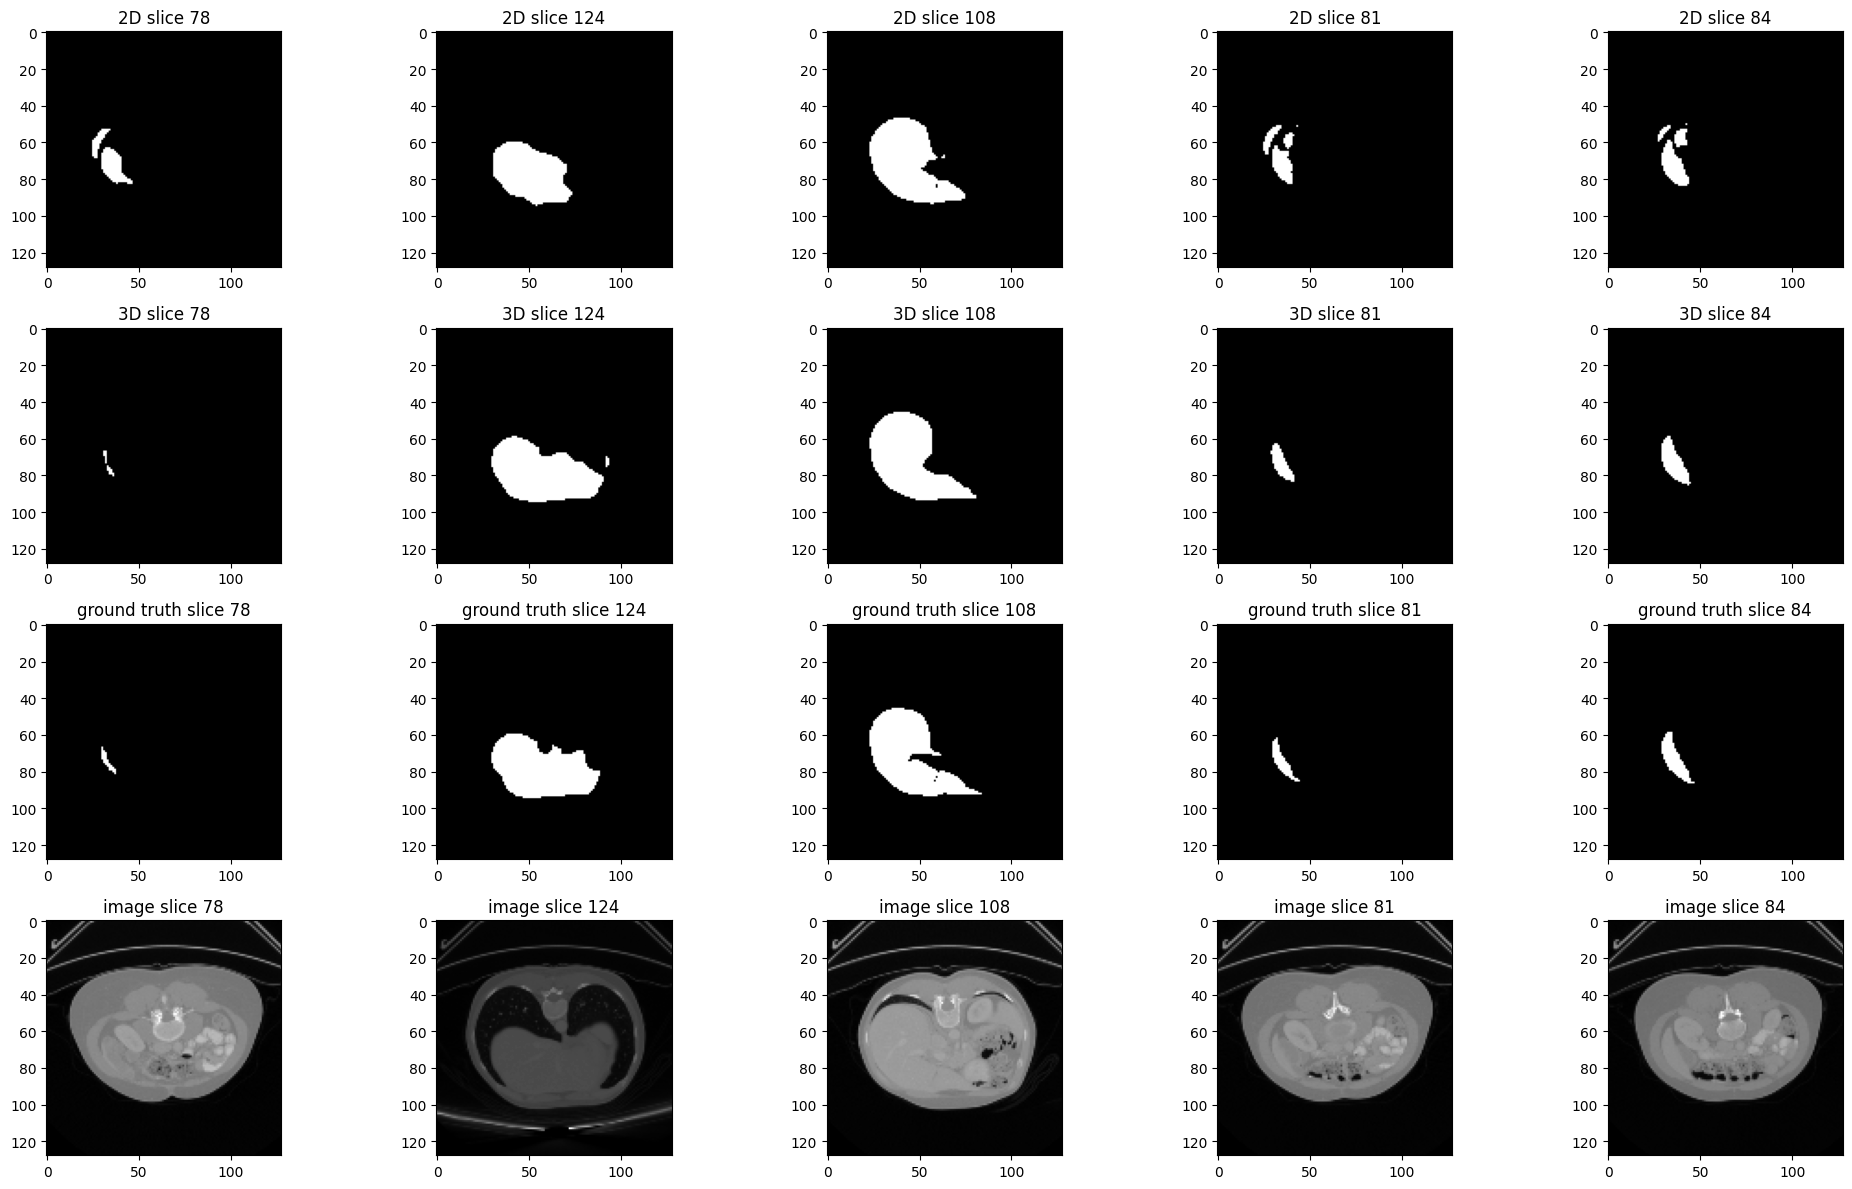

In [57]:
# -------------------------------- YOUR CODE --------------------------------
image, seg_mask = val_dataset_3d[9][0], val_dataset_3d[9][1]

input = torch.from_numpy(np.array([image])).type(torch.float)


model2D.eval()
model3D.eval()
# Unet 3D preddiction
outputs = model3D(input)
_, pred = torch.max(outputs, 1, keepdim=True)
pred_3d = pred[0]

slice_num = 5

fig, axs = plt.subplots(4, slice_num, figsize=(4*slice_num, 12))
for i, slic in enumerate(get_valid_n_slices(seg_mask, 5)):
  # Unet 2D preddiction
  outputs = model2D(input[:, :, slic])
  _, pred = torch.max(outputs, 1, keepdim=True)
  pred_2d = pred[0]

  axs[0][i].title.set_text(f"2D slice {slic}")
  axs[0][i].imshow(pred_2d[0], cmap='gray')

  axs[1][i].title.set_text(f"3D slice {slic}")
  axs[1][i].imshow(pred_3d[:, slic][0], cmap='gray')

  axs[2][i].title.set_text(f"ground truth slice {slic}")
  axs[2][i].imshow(seg_mask[:, slic][0], cmap='gray')

  axs[3][i].title.set_text(f"image slice {slic}")
  axs[3][i].imshow(image[:, slic][0], cmap='gray')

fig.tight_layout()
# -------------------------------- YOUR CODE --------------------------------